In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

def has_gaussian_noise(image, threshold=2):
    
    # Convert the image to grayscale if it's not already in grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Calculate the standard deviation of pixel values
    std_deviation = np.std(gray_image)

    # Check if the standard deviation is above the threshold
    if std_deviation > threshold:
        return True
    else:
        return False

def has_salt_and_pepper_noise(image, threshold=0.4):
    
    # Convert the image to grayscale if it's not already in grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Calculate the percentage of pixels with extreme values
    num_pixels = gray_image.size
    num_extreme_pixels = np.sum((gray_image == 0) | (gray_image == 255))
    percentage_extreme_pixels = num_extreme_pixels / num_pixels

    # Check if the percentage of extreme pixels is above the threshold
    if percentage_extreme_pixels > threshold:
        return True
    else:
        return False

def get_image_paths_and_labels(folder_path):
    image_paths = []
    labels = []

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return image_paths, labels

    # Iterate through the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a valid image
        if os.path.isfile(file_path) and filename.lower().endswith(('.jpg', '.jpeg')):
            image_paths.append(file_path)
            labels.append(filename)  # Use the filename as the label
            
    return image_paths, labels

# Example functions for data preprocessing
def load_and_preprocess_data(image_paths, labels, target_size=(256, 256)):
    # Load and preprocess MRI images
    images = []
    for path in image_paths:
        try:
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

            # Ensure the image has a valid size and aspect ratio
            if image is not None and image.shape[0] > 0 and image.shape[1] > 0:
                image = cv2.resize(image, target_size)  # Resize to a common size
                image = image / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                
        except Exception as e:
            print(f"Error processing image at path {path}: {str(e)}")

    # Convert images and labels to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

def data_augmentation(images):
    # Example data augmentation (rotate, flip, and add noise)
    augmented_images = []
    for image in images:
        augmented_image = image.copy()  # Create a copy of the original image

        if has_gaussian_noise(augmented_image) == True:
            augmented_image = cv2.GaussianBlur(augmented_image, (5, 5), 0)

        if has_salt_and_pepper_noise(augmented_image) == True:
            augmented_image = cv2.medianBlur(np.float32(augmented_image), 5)

        augmented_images.append(augmented_image)

    return np.array(augmented_images)

def is_corrupt_image(image_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None and image.shape[0] > 0 and image.shape[1] > 0:
            return False  # Image is not corrupt
        else:
            return True  # Image is corrupt
    except Exception as e:
        return True  # An error occurred when trying to open the image

def remove_corrupt_images(image_paths, labels):
    valid_image_paths = []
    valid_labels = []

    for i, path in enumerate(image_paths):
        if not is_corrupt_image(path):
            valid_image_paths.append(path)
            valid_labels.append(labels[i])

    return valid_image_paths, valid_labels



           
def split_data(images, labels):
    try:
        # Split data into training, validation, and test sets
        # Split data into training, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


        return X_train, y_train, X_val, y_val, X_test, y_test
    except ValueError as e:
        print(f"ValueError occurred during data splitting: {str(e)}")
        return None, None, None, None, None, None

folder_path_garbage = "./GarbageData/Garbage"
image_paths_garbage, labels_garbage = get_image_paths_and_labels(folder_path_garbage)

folder_path_non_garbage = "./GarbageData/NonGarbage"
image_paths_non_garbage, labels_non_garbage = get_image_paths_and_labels(folder_path_non_garbage)

image_paths = image_paths_garbage + image_paths_non_garbage
labels = labels_garbage + labels_non_garbage


for i in range(len(labels)):
    if "garbage" in labels[i]:
        labels[i] = 1
    else:
        labels[i] = 0

image_paths, labels = remove_corrupt_images(image_paths, labels)
images, labels = load_and_preprocess_data(image_paths, labels)
# Data augmentation
augmented_images = data_augmentation(images)

print("Number of images:", len(images))
print("Shape of images:", images.shape)
print("Number of labels:", len(labels))

# Check for missing labels
unique_labels = [0, 1]  # Unique labels expected in your dataset

for label in labels:
    if label not in unique_labels:
        print(f"Missing label: {label}")

# Check for duplicate labels
duplicate_labels = []
label_set = set()

for label in labels:
    if label in label_set:
        duplicate_labels.append(label)
    else:
        label_set.add(label)

if duplicate_labels:
    print("Duplicate labels found:", duplicate_labels)
else:
    print("No duplicate labels found")

# Split data (you had an issue here, so I fixed it)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(augmented_images, labels)

# Check for errors and handle accordingly
if X_train is None:
    # Handle the error gracefully, e.g., print an error message or log it
    print("Error occurred during data splitting.")
else:
    # Continue with model training or further processing
    print("Data preprocessing completed successfully.")

: 

In [16]:
len(labels)

3851

In [17]:
from keras import Sequential
from keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, PReLU, ELU
from keras.callbacks import EarlyStopping , ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

def custom_lr_schedule(epoch, current_lr):
    if epoch < 6:
        return 0.1  # Higher learning rate
    elif epoch < 15:
        return 0.01  # Medium learning rate
    else:
        return 0.001  # Slower learning rate

lr_scheduler = LearningRateScheduler(custom_lr_schedule)
    
model = Sequential()
model.add(InputLayer(input_shape=(256,256,1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=128, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=256, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=512, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(128, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(64, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('current_progress.h5', save_best_only=True)

model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       598144    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 128)      

In [19]:
history = model.fit(X_train,y_train,batch_size=32,epochs=30,verbose=1,validation_data=(X_val,y_val),callbacks=[lr_scheduler,early_stopping, reduce_lr, model_checkpoint])

Epoch 1/30
85/85 [==============================] - 85s 980ms/step - loss: 0.7184 - accuracy: 0.5573 - val_loss: 53029.6055 - val_accuracy: 0.5657 - lr: 0.1000
Epoch 2/30
85/85 [==============================] - 85s 993ms/step - loss: 0.6713 - accuracy: 0.6119 - val_loss: 57538.3008 - val_accuracy: 0.5104 - lr: 0.1000
Epoch 3/30
85/85 [==============================] - 85s 996ms/step - loss: 0.6539 - accuracy: 0.6430 - val_loss: 0.6924 - val_accuracy: 0.6903 - lr: 0.1000
Epoch 4/30
85/85 [==============================] - 81s 953ms/step - loss: 0.5967 - accuracy: 0.6939 - val_loss: 1.1665 - val_accuracy: 0.6834 - lr: 0.1000
Epoch 5/30
85/85 [==============================] - 80s 943ms/step - loss: 0.5713 - accuracy: 0.7169 - val_loss: 0.6158 - val_accuracy: 0.7128 - lr: 0.1000
Epoch 6/30
85/85 [==============================] - 80s 944ms/step - loss: 0.5462 - accuracy: 0.7347 - val_loss: 54863.1719 - val_accuracy: 0.6990 - lr: 0.1000
Epoch 7/30
85/85 [==============================] - 

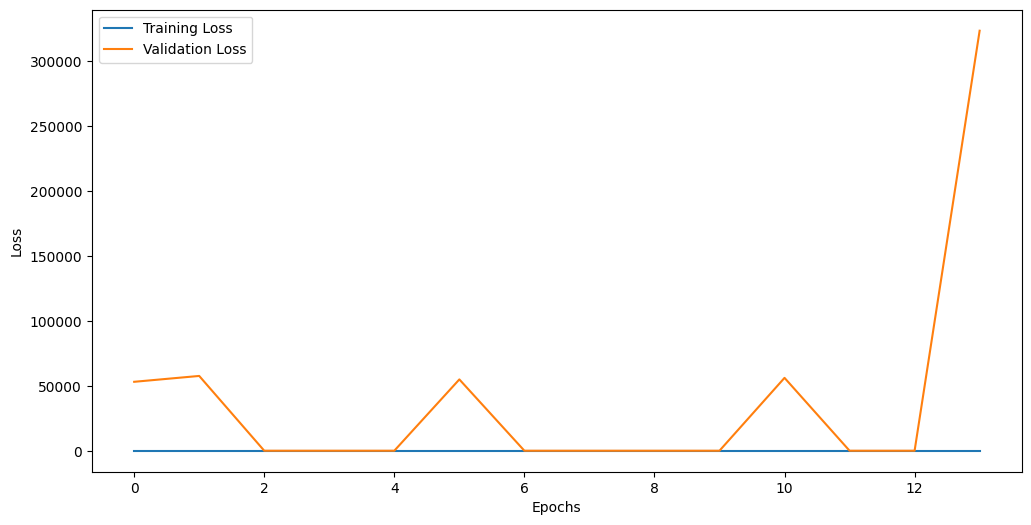

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

19/19 [==============================] - 5s 246ms/step


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred_binary,y_test)

array([[245,  84],
       [ 64, 185]])

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred_binary)

0.7439446366782007

In [24]:
from sklearn.metrics import f1_score

f1_score(y_test,y_pred_binary)

0.7142857142857143

In [1]:
def preprocess_and_augment_image(image_path, target_size=(256, 256)):
    try:
        # Load the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

        # Ensure the image has a valid size and aspect ratio
        if image is not None and image.shape[0] > 0 and image.shape[1] > 0:
            # Resize the image to the specified target size
            image = cv2.resize(image, target_size)
            # Normalize pixel values to [0, 1]
            image = image / 255.0

            # Check for noise and apply noise reduction if necessary
            if has_gaussian_noise(image):
                image = cv2.GaussianBlur(image, (5, 5), 0)
            if has_salt_and_pepper_noise(image):
                image = cv2.medianBlur(np.float32(image), 5)
            return image
        else:
            print("Invalid image dimensions or loading error.")
            return None
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

# Example usage:
image_path = "test1.jpeg"  
# image_path = "test2.jpg" 
# image_path = "test3.jpg" 
# image_path = "test4.jpg" 
# image_path = "test5.jpeg" 
# image_path = "test6.jpeg" 

# image_path = "nontest1.jpg" 
# image_path = "nontest2.jpg" 
# image_path = "nontest3.jpg" 
# image_path = "nontest4.jpg" 



preprocessed_image = preprocess_and_augment_image(image_path)

if preprocessed_image is not None:
    prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))
    if ((prediction > 0.5).astype(int))==0:
        detect = "No Garbage"
    else :
        detect = "Garbage"
    print("Predicted class: ",detect)


Error processing image: name 'cv2' is not defined


In [28]:
model.save('MyGarbageDetectionModelFinal2.h5')

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error

# Accuracy
accuracy = accuracy_score(y_test,y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test,y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test,y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,y_pred_binary)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test,y_pred_binary)
auc = roc_auc_score(y_test,y_pred_binary)
print("AUC:", auc)

Accuracy: 0.7439446366782007
Precision: 0.7429718875502008
Recall: 0.6877323420074349
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[245  64]
 [ 84 185]]
AUC: 0.7403063004535556
